# 10 階層ベイズモデル -GLMMのベイズモデル化-

In [10]:
import requests
import zipfile
import math
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
%precision 3

'%.3f'

In [3]:
# 全カラムを表示させる
pd.set_option('display.max_columns', None)

In [4]:
import warnings
warnings.filterwarnings('ignore')

## 10.1 例題：個体差と生存種子数(個体差あり)
著者サイトで公開されているデータを使います。

http://hosho.ees.hokudai.ac.jp/~kubo/ce/IwanamiBook.html

In [5]:
# 著者サイトからダウンロード
response = requests.get('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/hbm/data7a.csv')
with open ('data7a.csv', 'wb') as f:
    f.write(response.content)
    f.close()

In [6]:
# DataFrameへロード
data = pd.read_csv('data7a.csv')

data.head(3)

,id,y
0,1,0
1,2,2
2,3,7


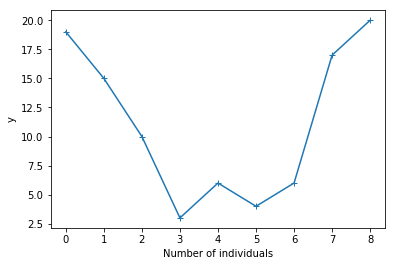

In [7]:
plt.plot(data.y.value_counts().sort_index(), marker='+')
plt.xlabel('Number of individuals')
plt.ylabel('y')
plt.show()

In [8]:
print('平均:', data.y.mean())
print('分散:', data.y.var())

平均: 4.03
分散: 9.92838383838384


## 10.2 GLMMの階層ベイズモデル化

全100個体の事後分布は二項分布に従う。

$$
p({\bf Y} \mid \beta, {r_i})=\prod_i \binom{8}{y_i} q_i^{y_i}(1-q_i)^{8-y_i}
$$

パラメータβは平均0・標準偏差100の正規分布に従う(無情報事前分布)。

$$
p(\beta)=\frac{1}{\sqrt{2\pi \times 100^2}} \exp(\frac{-\beta^2}{2 \times 100^2})
$$

パラメータrは平均0・標準偏差sの正規分布に従う(階層事前分布)。

$$
p(r_i \mid s)=\frac{1}{\sqrt{2\pi s^2}} \exp(\frac{-r_i^2}{2s^2})
$$

超パラメータsは0から10000の連続一様分布に従う(無情報事前分布、超事前分布)。

$$
p(s)=U(0, 10^4)
$$

## 10.3 階層ベイズモデルの推定・予測

In [11]:
# pip install pymc3
import pymc3 as pm

In [12]:
with pm.Model() as model:
    # βの事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta = pm.Normal('beta', mu=0, sd=100)
    
    # 超パラメータsの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    
    # パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # ロジットリンク関数を設定し、二項分布で推定する
    y = pm.Binomial('y', n=8, p=pm.invlogit(beta + r), observed=data.y.values)

Multiprocess sampling (3 chains in 3 jobs)
NUTS: [r, s_interval__, beta]
100%|██████████| 1600/1600 [00:53<00:00, 29.80it/s]
The acceptance probability does not match the target. It is 0.946106169449209, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9426593140542014, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9474823563990383, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,0.035392,0.341882,0.015033,-0.599800,0.722989,443.0,1.008236
s,3.052574,0.373706,0.010349,2.378439,3.802152,1051.0,1.002175


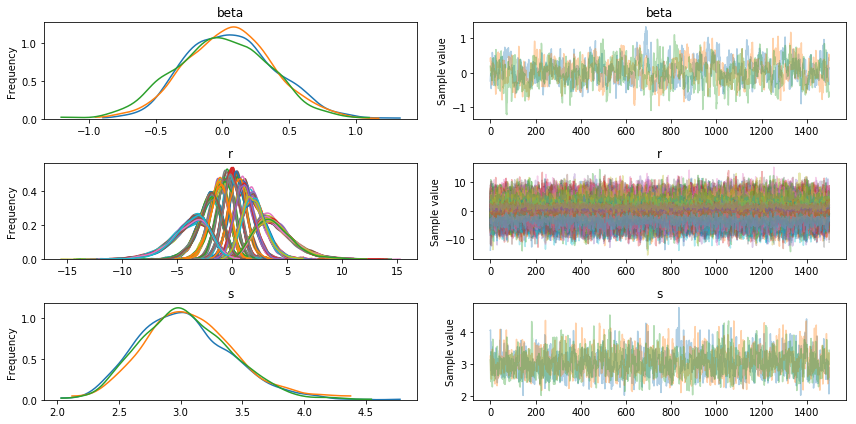

In [20]:
with model:
    # NUTSで101個目からサンプルを取得するチェインを3つ作る
    trace = pm.sample(1500, step=pm.NUTS(), tune=100, njobs=3, random_seed=0)
    
_ = pm.traceplot(trace)
pm.summary(trace).loc[['beta', 's']]

In [21]:
from scipy.stats import binom, norm

# 事後分布p(β|Y), p(s|Y)を3つのサンプル列の平均値で求める
beta_averages = np.zeros(len(trace), dtype=np.float64)
s_averages = np.zeros(len(trace), dtype=np.float64)

for i in trace.chains:
    beta_averages += trace.get_values('beta', chains=i) / trace.nchains
    s_averages += trace.get_values('s', chains=i) / trace.nchains

# シグモイド関数
q = lambda beta, r: 1 / (1 + math.exp(-(beta + r)))

# 全サンプル・全個体の種子数yの生存確率を計算
probs = []

for (beta, s) in zip(beta_averages, s_averages):
    individuals_probs = []
    
    # 100個体を生成
    for r in norm.rvs(loc=0, scale=s, size=100):
        y_probs = []
        
        # 各個体の種子数(0〜8個)の生存確率を計算
        for y in range(9):
            y_probs.append(binom.pmf(y, 8, q(beta, r)))
            
        individuals_probs.append(y_probs)
        
    probs.append(individuals_probs)
    
probs = np.array(probs)

print(probs.shape) # (1500, 100, 9)

(1500, 100, 9)


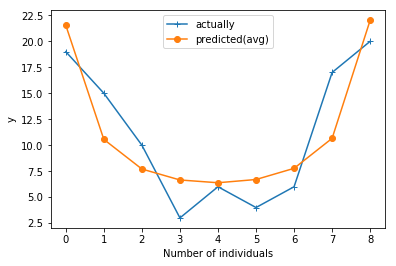

In [23]:
plt.plot(data.y.value_counts().sort_index(), marker='+', label='actually')
plt.plot(np.average(np.average(probs, axis=1), axis=0) * 100, marker='o', label='predicted(avg)')
plt.legend()
plt.xlabel('Number of individuals')
plt.ylabel('y')

## 10.5 個体差＋場所差の階層ベイズモデル

In [24]:
# 著者サイトからダウンロード
response = requests.get('http://hosho.ees.hokudai.ac.jp/~kubo/stat/iwanamibook/fig/hbm/nested/d1.csv')
with open ('d1.csv', 'wb') as f:
    f.write(response.content)
    f.close()

In [31]:
# DataFrameへロード
data = pd.read_csv('d1.csv')

data.head()

,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0


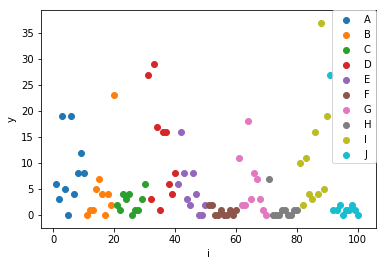

In [26]:
# 個体ごとの分布をプロット
for pot in data.pot.unique():
    plt.scatter(data[data.pot == pot].id, data[data.pot == pot].y, label=pot)
    
plt.legend(loc='upper right', borderaxespad=0)
plt.xlabel('i')
plt.ylabel('y')

[]

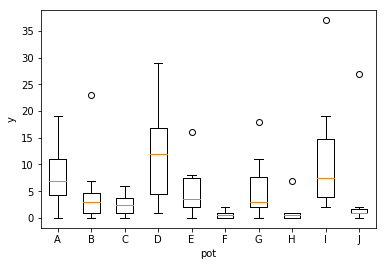

In [27]:
# 植木鉢ごとの分布を箱ひげ図でプロット
plt.boxplot([data[data.pot == p].y for p in data.pot.unique()], labels=data.pot.unique())
plt.xlabel('pot')
plt.ylabel('y')
plt.plot()

In [33]:
# T(施肥処理有り)の場合に1となる変数Fを追加
data['F'] = pd.get_dummies(data.f)['T']
# A〜Jを0〜9に対応付けた変数POTを追加
data['POT'] = data.pot.apply(lambda p: ord(p) - ord('A'))

data.head(3)

,id,pot,f,y,F,POT
0,1,A,C,6,0,0
1,2,A,C,3,0,0
2,3,A,C,19,0,0


Multiprocess sampling (3 chains in 3 jobs)
HamiltonianMC: [rp, r, sp_interval__, s_interval__, beta2, beta1]
100%|██████████| 1600/1600 [00:26<00:00, 60.63it/s]
The acceptance probability does not match the target. It is 0.9468215128743613, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9653005245927417, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9508657936900691, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta1,1.352641,0.520324,0.028068,0.357966,2.485375,318.0,0.999838
beta2,-0.847271,0.761082,0.041709,-2.242957,0.714441,301.0,1.000191
s,1.019230,0.116116,0.003499,0.809530,1.256813,1007.0,1.000320
sp,1.039450,0.374152,0.012848,0.437570,1.781125,756.0,0.999852


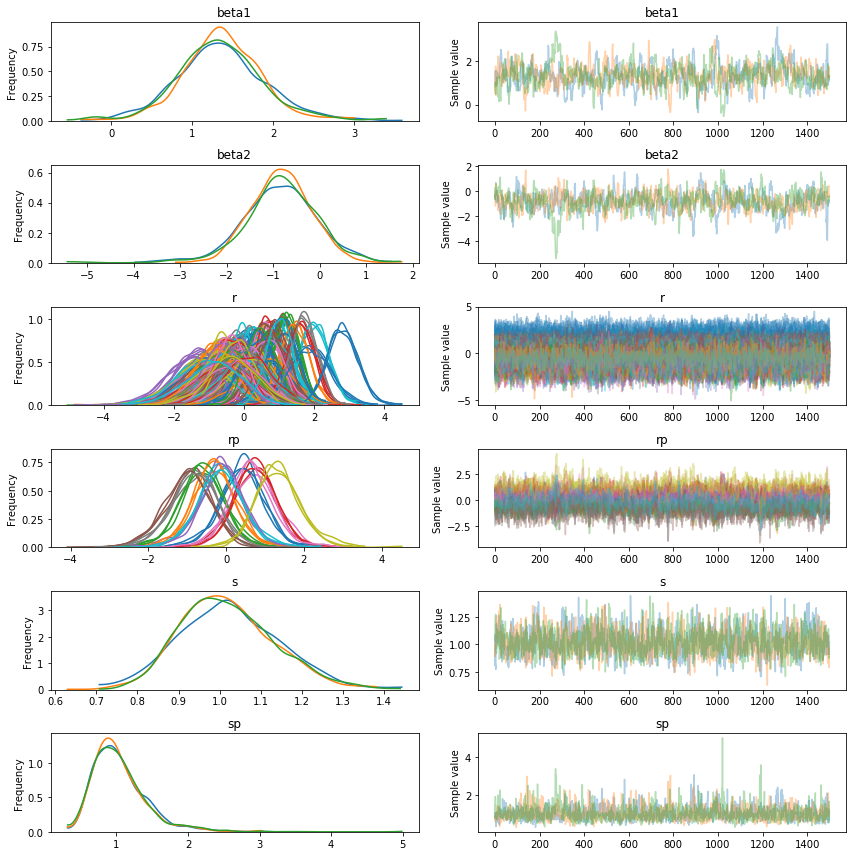

In [34]:
with pm.Model() as model:
    # β1とβ2の事前分布をN(0, 100)の正規分布で設定(無情報事前分布)
    beta1 = pm.Normal('beta1', mu=0, sd=100)
    beta2 = pm.Normal('beta2', mu=0, sd=100)
    
    # sとspの(超)事前分布をU(0, 10000)の連続一様分布で設定(無情報事前分布)
    s = pm.Uniform('s', lower=0, upper=10000)
    sp = pm.Uniform('sp', lower=0, upper=10000)
    
    # 個体差パラメータrの事前分布をN(0, s)の正規分布で設定(階層事前分布)
    r = pm.Normal('r', mu=0, sd=s, shape=len(data.y))
    
    # 場所差パラメータrpの事前分布をN(0, sp)の正規分布で設定(階層事前分布)
    rp = pm.Normal('rp', mu=0, sd=sp, shape=len(data.POT.unique()))
    
    # ログリンク関数を設定し、ポアソン分布で推定する
    y = pm.Poisson('y', mu=np.exp(beta1 + beta2 * data.F + r + rp[data.POT]), observed=data.y.values)
    
# HMCでサンプリング
with model:
    # 101個目からサンプルを取得するチェインを3つ作る
    trace = pm.sample(1500, step=pm.HamiltonianMC(), tune=100, njobs=3, random_seed=0)
    
_ = pm.traceplot(trace)

pm.summary(trace).loc[['beta1', 'beta2', 's', 'sp']]